### Loading Datasets

In [83]:
import pandas as pd

# Load datasets with empty strings treated as NaN
df_climate = pd.read_csv('../data/climate_scores.csv', na_values=[''])
df_cost = pd.read_csv('../data/cost_of_life_capitals.csv', na_values=[''])
df_coworking = pd.read_csv('../data/coworking_capitals.csv', na_values=[''])
df_death = pd.read_csv('../data/death_per_capital_2023.csv', na_values=[''])
df_internet = pd.read_csv('../data/internet_quality_capitals.csv', na_values=[''])
df_ips = pd.read_csv('../data/ips_capitals.csv', na_values=[''])

### Merging Datasets

In [84]:
# Standardize city names
df_climate['City'] = df_climate['City'].str.strip()
df_cost['City'] = df_cost['City'].str.strip()
df_coworking['capital'] = df_coworking['capital'].str.strip()
df_death['Capital'] = df_death['Capital'].str.strip()
df_internet['city'] = df_internet['city'].str.strip()

# Merge datasets
df_merged = (
    df_cost
    .merge(df_climate, on='City', how='left')
    .merge(df_internet.rename(columns={'city': 'City'}), on='City', how='left')
    .merge(df_coworking.rename(columns={'capital': 'City'}), on='City', how='left')
    .merge(df_death.rename(columns={'Capital': 'City'}), on='City', how='left')
    .merge(df_ips.rename(columns={'Município': 'City'}), on='City', how='left')
)

# Remove duplicates
df_merged.drop_duplicates(subset=['City'], keep='first', inplace=True)

df_merged.to_csv("analysis.csv", index=False, encoding="utf-8")

print(df_merged.head())

             City  1BR Apartment (Center)  1BR Apartment (Outside)  \
0       São Paulo                    3800                     2400   
1  Rio de Janeiro                    3200                     1900   
2        Brasília                    2700                     1600   
3  Belo Horizonte                    2200                     1300   
4       Fortaleza                    1700                     1000   

   Utilities (Monthly)  Internet (Monthly)  Groceries (Monthly)  \
0                  350                 160                  900   
1                  300                 150                  850   
2                  270                 140                  780   
3                  240                 130                  720   
4                  200                 110                  680   

   Public Transport (Monthly)  Cost Index  Avg Precipitation Days  \
0                         320          92               10.750000   
1                         290         

### Cleaning and Normalizing Data

In [89]:
# Columns for scoring
columns_to_normalize = [
    '1BR Apartment (Center)', '1BR Apartment (Outside)',
    'Utilities (Monthly)', 'Internet (Monthly)', 'Groceries (Monthly)', 
    'Public Transport (Monthly)', 'Climate Score', 'speed_mbps', 'Taxa_2023',
    'Índice de Progresso Social', 'Nutrição e Cuidados Médicos Básicos',
    'Água e Saneamento', 'Moradia', 'Segurança Pessoal', 'Saúde e Bem-estar'
]

# Custom normalization handling missing values
df_normalized = df_merged[['City'] + columns_to_normalize].copy()

for col in columns_to_normalize:
    if pd.api.types.is_numeric_dtype(df_normalized[col]):
        # Calculate min/max ignoring NaN values
        col_min = df_normalized[col].min(skipna=True)
        col_max = df_normalized[col].max(skipna=True)
        
        # Handle case where all values are the same
        if col_max == col_min:
            df_normalized[col] = 0.5  # Midpoint value
        else:
            df_normalized[col] = (df_normalized[col] - col_min) / (col_max - col_min)

# Calculate composite score using available metrics only
score_columns = [col for col in columns_to_normalize if col in df_normalized]
df_normalized['Composite_Score'] = df_normalized[score_columns].mean(axis=1, skipna=True)

# Save results
df_normalized.to_csv("analyse.csv", index=False)

print("Final normalized data with composite scores:")
print(df_normalized[['City', 'Composite_Score'] + columns_to_normalize])

Final normalized data with composite scores:
              City  Composite_Score  1BR Apartment (Center)  \
0        São Paulo         0.807257                1.000000   
1   Rio de Janeiro         0.613851                0.769231   
2         Brasília         0.669711                0.576923   
3   Belo Horizonte         0.550366                0.384615   
4        Fortaleza         0.377709                0.192308   
5         Salvador         0.353802                0.269231   
6         Curitiba         0.504939                0.346154   
7           Recife         0.288373                0.230769   
8     Porto Alegre         0.452675                0.307692   
9          Goiânia         0.482993                0.153846   
10          Manaus         0.300265                0.076923   
11           Natal         0.255302                0.038462   
12     João Pessoa         0.309335                0.057692   
13        Teresina         0.261006                0.000000   
14    Camp

In [87]:
from sklearn.preprocessing import MinMaxScaler

# Select relevant columns for scoring
columns_to_normalize = [
    # Cost of Living
    '1BR Apartment (Center)', '1BR Apartment (Outside)',
    'Utilities (Monthly)', 'Internet (Monthly)', 'Groceries (Monthly)', 'Public Transport (Monthly)',
    
    # Climate
    'Climate Score',
    
    # Internet
    'speed_mbps',
    
    # Safety
    'Taxa_2023',
    
    # Quality of Life
    'Índice de Progresso Social', 'Nutrição e Cuidados Médicos Básicos',
    'Água e Saneamento', 'Moradia', 'Segurança Pessoal', 'Saúde e Bem-estar'
]

# Normalize selected columns
scaler = MinMaxScaler()
df_normalized = df_merged[columns_to_normalize].copy()
df_normalized[columns_to_normalize] = scaler.fit_transform(df_normalized[columns_to_normalize])

# Add back city names
df_normalized.insert(0, 'City', df_merged['City'])
df_normalized.to_csv("analyse.csv", index=False, encoding="utf-8")

print(df_normalized)

              City  1BR Apartment (Center)  1BR Apartment (Outside)  \
0        São Paulo                1.000000                 1.000000   
1   Rio de Janeiro                0.769231                 0.705882   
2         Brasília                0.576923                 0.529412   
3   Belo Horizonte                0.384615                 0.352941   
4        Fortaleza                0.192308                 0.176471   
5         Salvador                0.269231                 0.235294   
6         Curitiba                0.346154                 0.294118   
7           Recife                0.230769                 0.176471   
8     Porto Alegre                0.307692                 0.235294   
9          Goiânia                0.153846                 0.147059   
10          Manaus                0.076923                 0.058824   
11           Natal                0.038462                 0.029412   
12     João Pessoa                0.057692                 0.058824   
13    

### Creating Composite Score for Remote Work Attractiveness

In [94]:
# Modified weighting calculation that ignores missing values
weights = {
    '1BR Apartment (Center)': -0.05, # Lower cost = better
    '1BR Apartment (Outside)': -0.05, # Lower cost = better
    'Utilities (Monthly)': -0.05,
    'Internet (Monthly)': -0.05,
    'Groceries (Monthly)': -0.05,
    'Public Transport (Monthly)': -0.05,
    'Climate Score': 0.1,  
    'speed_mbps': 0.1,
    'Taxa_2023': -0.1,  # Lower mortality = better
    'Índice de Progresso Social': 0.1,
    'Nutrição e Cuidados Médicos Básicos': 0.05,
    'Água e Saneamento': 0.1,
    'Moradia': 0.1,
    'Segurança Pessoal': 0.1,
    'Saúde e Bem-estar': 0.1
}

# Calculate weighted score ignoring missing values
df_normalized['Remote Work Score'] = df_normalized.apply(
    lambda row: sum(
        row[col] * weight 
        for col, weight in weights.items() 
        if not pd.isna(row[col])  # Skip missing values
    ),
    axis=1
)

# Normalize the final score between 0-100 based on actual present values
max_score = df_normalized['Remote Work Score'].max()
min_score = df_normalized['Remote Work Score'].min()
df_normalized['Remote Work Score'] = ((df_normalized['Remote Work Score'] - min_score) / 
                                      (max_score - min_score))

# Sort by score
df_ranked = df_normalized.sort_values(by='Remote Work Score', ascending=False).reset_index(drop=True)
print(df_ranked[['City', 'Remote Work Score']])

              City  Remote Work Score
0          Goiânia           1.000000
1           Cuiabá           0.959424
2    Florianópolis           0.907709
3         Brasília           0.796410
4           Palmas           0.789209
5   Belo Horizonte           0.768698
6     Campo Grande           0.754304
7         Curitiba           0.728054
8          Aracaju           0.635873
9      João Pessoa           0.634560
10         Vitória           0.606097
11       Boa Vista           0.605730
12        Teresina           0.589547
13    Porto Alegre           0.547805
14       São Paulo           0.525917
15           Belém           0.489048
16           Natal           0.479795
17       Fortaleza           0.473371
18          Manaus           0.423839
19     Porto Velho           0.265428
20  Rio de Janeiro           0.240359
21          Maceió           0.205430
22          Recife           0.149477
23        Salvador           0.149062
24          Macapá           0.000000


### Visualization

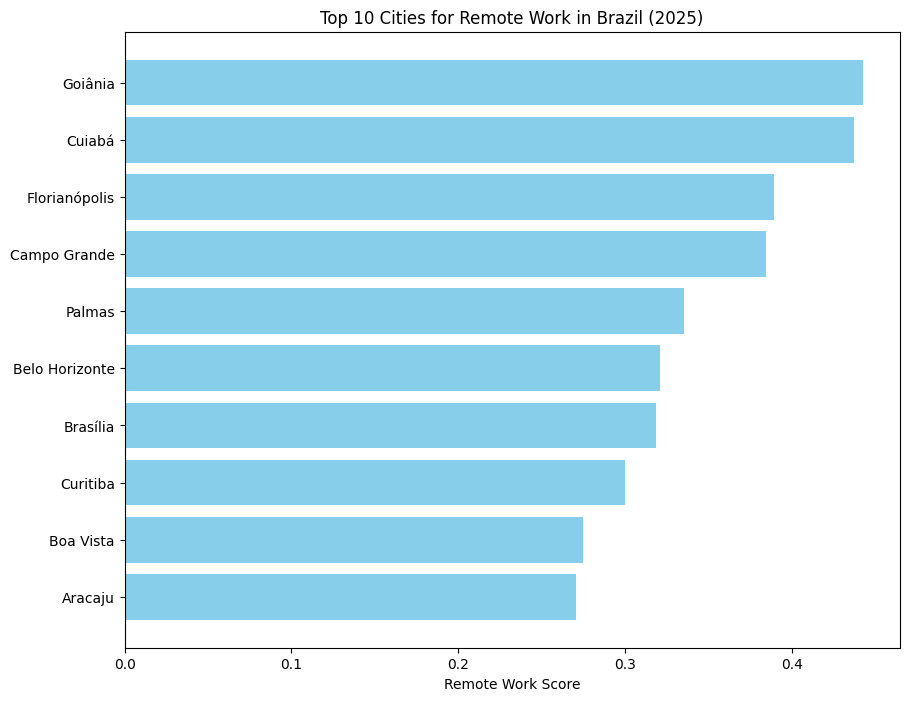

In [75]:
import matplotlib.pyplot as plt

top_10 = df_ranked.head(10)
plt.figure(figsize=(10, 8))
plt.barh(top_10['City'], top_10['Remote Work Score'], color='skyblue')
plt.xlabel('Remote Work Score')
plt.title('Top 10 Cities for Remote Work in Brazil (2025)')
plt.gca().invert_yaxis()  # Show best at the top
plt.show()

In [21]:
from sklearn.cluster import KMeans

# Choose features for clustering
features_for_clustering = ['Remote Work Score']

# Apply K-means
kmeans = KMeans(n_clusters=3, random_state=42)
df_ranked['Cluster'] = kmeans.fit_predict(df_ranked[features_for_clustering])

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values